# Example: Understanding the Secret Messages Inside of the Yield Curve
In this example, we will explore the yield curve, i.e., the change in interest rates for different maturity coupon-bearing Treasury securities. Beyond its direct value of understanding the pricing of Treasury securities, the yield curve has been used as a recession indicator, a theory postulated in the [PhD thesis of Prof. Campbell Harvey at Duke](https://people.duke.edu/~charvey/). In the past, it has had good predictive value; what's it saying now? Let's dive into the current implications and analysis.

### Learning objectives
This example will familiarize students with working with Treasury yield datasets, the concept of the [Par-yield curve](https://en.wikipedia.org/wiki/Par_yield), and computing a recession indicator.
* __Prerequisite__: Load the Treasury Rates Dataset. First, we'll load the Treasury data set we'll use in the subsequent tasks, and set up some other stuff required for the subsequent calculations.
* __Task 1__: Which yield curve should we look at? In this task, we'll look at different possible yield curves and introduce (and test) the [Par-yield curve](https://en.wikipedia.org/wiki/Par_yield) idea.
* __Task 2__: Let's compute and analyze a recession indicator. In this task, we'll compute a recession indicator from the reported Treasury securities dataset and determine if it is signaling the possibility of a future recession. 

What do we see now?
___

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources such as sample datasets, and setting up any required constants. 

> __Include:__ The [include(...) function](https://docs.julialang.org/en/v1/base/base/#include) is a convenient way to load Julia code from another file. The `Include.jl` file is a Julia file that loads external packages and various functions that we will use in this exercise. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Otherwise, packages are downloaded and then loaded.

Set up the environment:

In [1]:
include("Include.jl");

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
In this section, we'll load the data we'll use and set up some other requirements for the subsequent calculations. First, specify which year (as a `YYYY` string) of data in the `year_of_data::String` variable that we are going to explore; we have data for `{2020, 2021, 2022, 2023, 2024, 2025}`. Note the `2025` data is year-to-date.

In [2]:
year_of_data = "2025"; # we have data for {2020, 2021, 2022, 2023, 2024, 2025}

Now that we have a value for the `year_of_data::String`, we can load the data for the yield curve study. The yield curve data is available from the [United States Treasury](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics) in a [`CSV` flat-file format](https://en.wikipedia.org/wiki/Comma-separated_values). We've already downloaded several years' worth of data and saved it in the `<root>/data` directory. To load a year's data, we use [the `read(...)` exported by the CSV.jl package](https://github.com/JuliaData/CSV.jl) and save the data in the `par_yield_curve_dataset::DataFrame` variable.

What is going on in the [`read(...)` method call](https://csv.juliadata.org/stable/reading.html#CSV.read)? This method requires a path to the data file, specified [using the Julia `joinpath(...)` method](https://docs.julialang.org/en/v1/base/file/#Base.Filesystem.joinpath), and a type to load the data into, specified as a [`DataFrame` type exported by the DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl). We use [the Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) in combination with the [Julia `reverse(...)` method](https://docs.julialang.org/en/v1/base/arrays/#Base.reverse-Tuple{AbstractVector}) to put the data into date-ascending order.

In [3]:
par_yield_curve_dataset = CSV.read(joinpath(_PATH_TO_DATA, "UST-Daily-ParYieldCurveRates-$(year_of_data).csv"), DataFrame) |> reverse

Row,Date,1 Mo,1.5 Month,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
,String15,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,01/02/2025,4.45,missing,4.36,4.36,4.31,4.25,4.17,4.25,4.29,4.38,4.47,4.57,4.86,4.79
2,01/03/2025,4.44,missing,4.35,4.34,4.31,4.25,4.18,4.28,4.32,4.41,4.51,4.6,4.88,4.82
3,01/06/2025,4.43,missing,4.36,4.35,4.31,4.24,4.17,4.28,4.3,4.42,4.52,4.62,4.91,4.85
4,01/07/2025,4.42,missing,4.35,4.35,4.31,4.24,4.19,4.3,4.33,4.46,4.57,4.67,4.97,4.91
5,01/08/2025,4.41,missing,4.34,4.35,4.31,4.25,4.19,4.28,4.31,4.45,4.56,4.67,4.97,4.91
6,01/09/2025,4.44,missing,4.36,4.35,4.31,4.24,4.16,4.27,4.31,4.46,4.57,4.68,4.98,4.92
7,01/10/2025,4.42,missing,4.35,4.36,4.33,4.27,4.25,4.4,4.46,4.59,4.7,4.77,5.04,4.96
8,01/13/2025,4.42,missing,4.36,4.37,4.34,4.3,4.24,4.4,4.49,4.61,4.71,4.79,5.05,4.97
9,01/14/2025,4.42,missing,4.35,4.36,4.33,4.29,4.22,4.37,4.46,4.59,4.7,4.78,5.06,4.98


Finally, we'll do Treasury security pricing calculations requiring a compounding model below. Treasury securities are priced at auction using discrete compounding. Thus, we create [a `DiscreteCompoundingModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.DiscreteCompoundingModel) and save it to the `discount_model` variable.

In [4]:
discount_model = DiscreteCompoundingModel();

___

## Task 1: Which yield curve should we be looking at?
The [United States Treasury](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics) reports multiple types of interest rate statistics each business day that we _could_ use to understand how the Treasury market perceives current and future economic growth, for example:
* The [Par Yield Curve Rates](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics) is based on the closing market bid prices on the most recently auctioned Treasury securities in the over-the-counter market. The par yields are derived from input market prices, which are indicative quotations obtained by the [Federal Reserve Bank of New York at approximately 3:30 PM each business day](https://www.newyorkfed.org/data-and-statistics). For information on how the Treasury’s yield curve is derived, visit [the Treasury Yield Curve Methodology page](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/treasury-yield-curve-methodology).
* The [Daily Treasury Par Real Yield Curve Rates](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics), which relates the par real yield on a [Treasury Inflation Protected Security (TIPS)](https://www.treasurydirect.gov/marketable-securities/tips/) to its time to maturity, is based on the closing market bid prices on the most recently auctioned TIPS in the over-the-counter market. The par yields are derived from input market prices, which are indicative quotations obtained by the [Federal Reserve Bank of New York at approximately 3:30 PM each business day](https://www.newyorkfed.org/data-and-statistics).
* The [Daily Treasury Bill Rates](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics) are indicative closing market bid quotations on the most recently auctioned Treasury Bills in the over-the-counter market as obtained by the [Federal Reserve Bank of New York at approximately 3:30 PM each business day](https://www.newyorkfed.org/data-and-statistics). However, these are all short-term instruments, so these will not be good for contrasting a long-term versus a short-term outlook. 

Let's explore [the Par Yield Curve Rates](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics) and try to understand what they mean.

### Let's explore the Par-yield curve
When the effective discount rate $\bar{r}$ equals the coupon rate $\bar{c}$, a coupon note (or bond) will trade at its par value, i.e., $V_{P} = V_{B}$ for all maturities. Let's test this out by constructing [a `MyUSTreasuryCouponSecurityModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.MyUSTreasuryCouponSecurityModel) with some typical parameters and show this claim is valid. 

Start by setting some typical parameter values:

In [5]:
Vₚ = 100.0; # par value for the note/bond
r̄ = 0.05;
c̄ = 0.05;
T = 1.0; # needs to be 0.5 or greater; see below
λ = 2; # this is n (different notion)

Then construct [a `MyUSTreasuryCouponSecurityModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.MyUSTreasuryCouponSecurityModel) by passing the type we want to build, i.e., [`MyUSTreasuryCouponSecurityModel`](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.MyUSTreasuryCouponSecurityModel) and some typical data for the `par` value, the discount `rate`, the `coupon` rate, the duration `T` (years), and the number of compounding events per year `λ = 2` into a [custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.build-Tuple{Type{MyUSTreasuryCouponSecurityModel},%20NamedTuple}). We save this as the `my_treasury_security_model::MyUSTreasuryCouponSecurityModel` variable.

We compute (and populate on the model instance) the `price` and other data fields, such as the cashflow table, for the `my_treasury_security_model::MyUSTreasuryCouponSecurityModel` by passing this model to the `discount_model` using the [built-in Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping).

In [6]:
my_treasury_security_model = build(MyUSTreasuryCouponSecurityModel, (
    par = Vₚ,
    rate = r̄,
    coupon = c̄,
    T = T,
    λ = λ
)) |> discount_model;

Finally, use the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to verify the $V_{B} = V_{P}$ claim. If the claim is false, i.e., $V_{P} \neq V_{B}$ when $\bar{r} = \bar{c}$, an [`AssertionError` type is thrown](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError). We use the [Julia `isapprox(...)` method to check for equality](https://docs.julialang.org/en/v1/base/math/#Base.isapprox).

In [7]:
@assert isapprox(my_treasury_security_model.price, Vₚ, rtol=1e-4) # checks equality to `rtol` value

### Cashflow table for the test case
`Unhide` the code block below to see how we constructed the cashflow table for the `my_treasury_security_model` using [the `pretty_table(...)` method exported by the PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl).
 > __Summary__: Each row in the table shows data for a cashflow event (typically two per year), where the discount rate, the nominal and discounted cashflows, and the discounted cumulative cash flows are presented for each event. At maturity, the discounted cumulative cash flow equals zero (NPV = 0), demonstrating that the net present value of the investment (purchase price plus discounted cash flows) equals zero when the coupon rate equals the discount rate.

 Let's make the table.

In [8]:
let
    cashflow = my_treasury_security_model.cashflow;
    discount = my_treasury_security_model.discount;
    number_of_periods = length(cashflow)
    bond_data_table = Array{Any,2}(undef, number_of_periods, 5);
    sumvalue = 0.0;
    for i ∈ 0:(number_of_periods - 1)
    
        discount_value = discount[i]
        payment = cashflow[i];
        sumvalue += payment;

        bond_data_table[i+1,1] = i;
        bond_data_table[i+1,2] = discount_value;
        bond_data_table[i+1,3] = discount_value*payment;
        bond_data_table[i+1,4] = payment;
        bond_data_table[i+1,5] = sumvalue;
    end
    pretty_table(bond_data_table; 
        header=["Event", "Discount", "Nominal cashflow events", "Discounted cashflow events", "Discounted cumulative cashflow"], 
        tf = tf_simple)
end

======== ========== ========================= ============================ =================================
  Event   Discount   Nominal cashflow events   Discounted cashflow events   Discounted cumulative cashflow 
======== ========== ========================= ============================ =================================
      0        1.0                    -100.0                       -100.0                           -100.0
      1      1.025                       2.5                      2.43902                          -97.561
      2    1.05062                     102.5                       97.561                              0.0
======== ========== ========================= ============================ =================================


### Check: Treasury Prices from the Par Yield Curve Data
We showed that the `Par-Yield` convention gives a Treasury security priced at par, i.e., $V_{B} = V_{P}$ for a test bond. However, we still need to check that this equality holds for the [Par-Yield curve data](https://en.wikipedia.org/wiki/Comma-separated_values) that we downloaded. Write code to check the $V_{B} = V_{P}$ condition for the downloaded data.
* First, convert the maturity values listed as the column headers in the `par_yield_curve_dataset::DataFrame` to floating-point values for the pricing calculations. Let's store the converted floating-point maturity values in the `maturity_conversion_dict::Dict{String, Float64}` dictionary where the keys are the maturity header strings, i.e., `3 Mo` or `10 Yr`, and the values are the converted floating-point values in units of years, assuming a 12-month year.
* We iterate through the column headers and check if we have a month- or year-based Treasury security. By default, we assume we have a year-based security and correct for shorter-duration instruments. For shorter-duration securities, we convert to years assuming the `basis` number of months per year.
* We use [the Julia `split(...)` method](https://docs.julialang.org/en/v1/base/strings/#Base.split) to tokenize the column string around the `space` character into two fragments, the duration fragment and the unit fragment. Depending upon the unit, we do a different unit conversion.

Let's compute the maturity conversion dictionary.

In [9]:
maturity_conversion_dict = let

    # initialize -
    maturity_conversion_dict = Dict{String, Float64}();
    basis = 12; # assume a 12-month year
    list_of_columns = names(par_yield_curve_dataset)
    
    
    # compute the conversion dictionary
    for column ∈ list_of_columns 
        if (column != "Date")

            # split around the space, and convert to appropriate type
            maturity_fragments = split(column, " "); # split around the space
            duration = maturity_fragments |> first |> string |> x-> parse(Float64, x);
            unit = maturity_fragments |> last;

            # assume: default is years, correct if we have months
            maturity_conversion_dict[column] = duration;
            if (unit == "Mo")
                maturity_conversion_dict[column] = (duration/basis);    
            end
        end
    end
    maturity_conversion_dict
end

Dict{String, Float64} with 14 entries:
  "3 Mo"      => 0.25
  "20 Yr"     => 20.0
  "30 Yr"     => 30.0
  "1.5 Month" => 1.5
  "6 Mo"      => 0.5
  "1 Yr"      => 1.0
  "2 Mo"      => 0.166667
  "10 Yr"     => 10.0
  "5 Yr"      => 5.0
  "2 Yr"      => 2.0
  "4 Mo"      => 0.333333
  "1 Mo"      => 0.0833333
  "7 Yr"      => 7.0
  "3 Yr"      => 3.0

Finally, we compute the price and store it in the `reverse_price_array::Array{Float64,2}` using [a nested `for loop`](https://docs.julialang.org/en/v1/base/base/#for). Each row of the `reverse_price_array` corresponds to a day in the dataset, while each column corresponds to a different duration Treasury security. 

In [10]:
reverse_price_array = let
    
    list_of_columns = names(par_yield_curve_dataset)
    number_of_dates = nrow(par_yield_curve_dataset);
    number_of_columns = names(par_yield_curve_dataset) |> length
    reverse_price_array = Array{Float64,2}(undef, number_of_dates, number_of_columns - 1);
    
    for i ∈ 1:number_of_dates
        for j ∈ 2:number_of_columns

            column = list_of_columns[j];
            r̄ = par_yield_curve_dataset[i, column]*(1/100);
            c̄ = r̄; # set coupon rate equal to discount rate for par pricing
            T_maturity = column |> key -> maturity_conversion_dict[key];

            if (ismissing(r̄) == true)
               r̄ = 0.0
            end

            if (ismissing(c̄) == true)
                c̄ = 0.0;
            end
            
            # Create a new model for each calculation to avoid mutation issues
            temp_model = build(MyUSTreasuryCouponSecurityModel, (
                par = Vₚ, # defined above, this is the par value of the note/bond
                rate = r̄,
                coupon = c̄,
                T = T_maturity,
                λ = λ # defined above, this is the number of compounding periods per year
            )) |> discount_model;
            
            reverse_price_array[i,j-1] = temp_model.price;
        end
    end
    reverse_price_array
end

171×14 Matrix{Float64}:
 99.6339  100.0  99.2837  98.9275  …  100.0  100.0  100.0  100.0  100.0
 99.6347  100.0  99.2853  98.9323     100.0  100.0  100.0  100.0  100.0
 99.6355  100.0  99.2837  98.9299     100.0  100.0  100.0  100.0  100.0
 99.6363  100.0  99.2853  98.9299     100.0  100.0  100.0  100.0  100.0
 99.6372  100.0  99.287   98.9299     100.0  100.0  100.0  100.0  100.0
 99.6347  100.0  99.2837  98.9299  …  100.0  100.0  100.0  100.0  100.0
 99.6363  100.0  99.2853  98.9275     100.0  100.0  100.0  100.0  100.0
 99.6363  100.0  99.2837  98.9251     100.0  100.0  100.0  100.0  100.0
 99.6363  100.0  99.2853  98.9275     100.0  100.0  100.0  100.0  100.0
 99.638   100.0  99.287   98.9299     100.0  100.0  100.0  100.0  100.0
  ⋮                                ⋱           ⋮                  
 99.6363  100.0  99.287   98.9469     100.0  100.0  100.0  100.0  100.0
 99.6363  100.0  99.2934  98.9517     100.0  100.0  100.0  100.0  100.0
 99.6363  100.0  99.2918  98.9517     100.0  

#### Hmmm. What is going on with the short-range instruments?
We do not capture the pricing of instruments with a maturity shorter than six months. __This is an open issue__; we are working to figure out what is going on with very short-term instruments [see the pricing algorithm's implementation; give us some help!](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.price). 

___

## Task 2: Let's compute and analyze a recession indicator
In this task, we'll compute a recession indicator from the reported Treasury securities dataset and determine if it is signaling the possibility of a future recession. First, specify two maturities in the dataset, a short-term and long-term maturity value in the `short_maturity_key` and `long_maturity_key` variables, respectively. These will be the column header strings in the `par_yield_curve_dataset::DataFrame` dataset.

In [ ]:
short_maturity_key = "7 Yr"; # short-term maturity
long_maturity_key = "30 Yr"; # long-term maturity

Next, compute the indicator. [Prof. Harvey](https://people.duke.edu/~charvey/) proposed a long minus a short maturity, so let's subtract the `short_maturity_key` maturity from the `long_maturity_key` instrument and store it in the `indicator_array::Array{Float64,2}` array. We process each date in the dataset using a [`for-loop`](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Loops-and-Comprehensions). 

For each iteration of the loop, 
* We access the short- and long-duration rates from the `par_yield_curve_dataset` for that day; we store these values in the first and second column of the `indicator_array::Array{Float64,2}.` 
* Then, we compute the indicator and store it in the third column of `indicator_array,` where each row of `indicator_array` corresponds to a different date.  

So what is the indicator telling us now?

In [12]:
indicator_array = let

    # initialize -
    number_of_dates = nrow(par_yield_curve_dataset); # ensure we have the count
    indicator_array = Array{Float64,2}(undef, number_of_dates,3);
    
    # compute
    for i ∈ 1:number_of_dates
        short_date_yield = par_yield_curve_dataset[i,short_maturity_key]
        long_date_yield = par_yield_curve_dataset[i,long_maturity_key]
        
        indicator_array[i,1] = short_date_yield;
        indicator_array[i,2] = long_date_yield;
        indicator_array[i,3] = long_date_yield - short_date_yield;
    end

    indicator_array; # return
end

171×3 Matrix{Float64}:
 4.36  4.79  0.43
 4.34  4.82  0.48
 4.35  4.85  0.5
 4.35  4.91  0.56
 4.35  4.91  0.56
 4.35  4.92  0.57
 4.36  4.96  0.6
 4.37  4.97  0.6
 4.36  4.98  0.62
 4.35  4.88  0.53
 ⋮           
 4.28  4.9   0.62
 4.26  4.91  0.65
 4.26  4.88  0.62
 4.23  4.92  0.69
 4.2   4.97  0.77
 4.18  4.9   0.72
 4.16  4.86  0.7
 4.07  4.78  0.71
 4.1   4.69  0.59

### Visualize and analyze yield data
`Unhide` the code block below to see how we visualized the par yield for the short-term and long-term maturity values from the `year_of_data` specified above.  
> __Summary__: The orange line represents the par yield of the long maturity instrument, while the blue line represents the shorter maturity security. Under normal economic conditions, the longer-duration yield should be higher than that of the shorter-term security. However, during a period of inversion, the opposite is true. For an inversion to signal a recession, we need to see at least one consecutive quarter of inversion.

Let's make the plot.

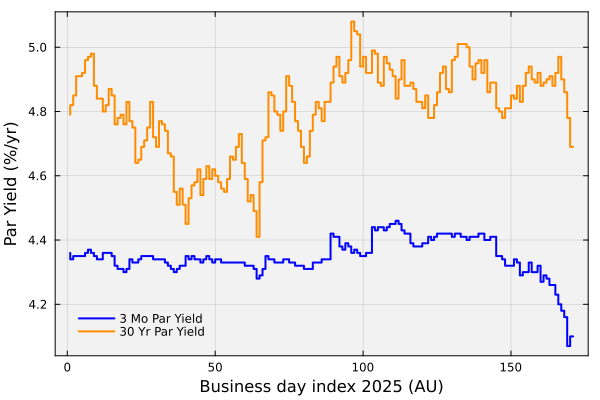

In [13]:
let
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    plot(q, indicator_array[:,1], lw=2, c=:blue, label="$(short_maturity_key) Par Yield", linetype=:steppre)
    plot!(indicator_array[:,2], lw=2, c=:darkorange, label="$(long_maturity_key) Par Yield", linetype=:steppre)
    xlabel!("Business day index $(year_of_data) (AU)", fontsize=18)
    ylabel!("Par Yield (%/yr)", fontsize=18)
end

#### Do we have a recession signal?
`Unhide` the code block below to see how we visualized the `indicator_array::Array{Float64}` data for values of the maturity keys specified above.

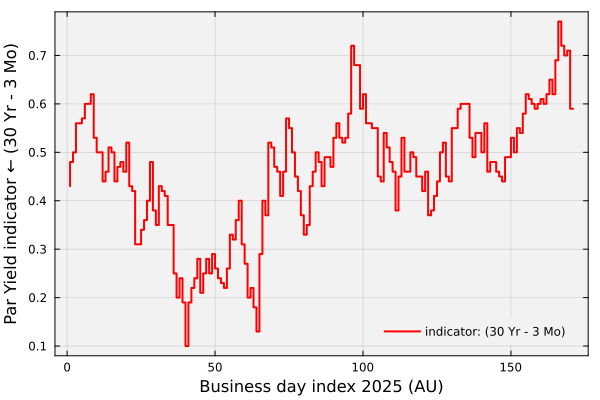

In [14]:
let
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    plot(q, indicator_array[:,3], lw=2, c=:red, label="indicator: ($(long_maturity_key) - $(short_maturity_key))", linetype=:steppre)
    xlabel!("Business day index $(year_of_data) (AU)", fontsize=18)
    ylabel!("Par Yield indicator ← ($(long_maturity_key) - $(short_maturity_key))", fontsize=18)
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.